# Analysing my Spotify rock playlist

Since 2015 I've been adding my most-liked rock songs to the aptly named playlist *Favourite Rock*.


I thought it'd be fun to use content metadata from Spotify's [Web API](https://developer.spotify.com/documentation/web-api) to learn more about my taste in rock music, such as favourite music era and how often I've added to the playlist over the years.

In [16]:
import os

import requests
import pandas as pd

## Getting the data

In [17]:
# Getting the API access token.
url = "https://accounts.spotify.com/api/token"

headers = {
    "Content-Type": "application/x-www-form-urlencoded"
}

data = {
    "grant_type": "client_credentials",
    "client_id": os.environ['SPOTIFY_CLIENT_ID'],
    "client_secret": os.environ['SPOTIFY_CLIENT_SECRET']
}

response = requests.post(url, headers=headers, data=data)
token = response.json()['access_token']

The **[Get Playlist Items](https://developer.spotify.com/documentation/web-api/reference/get-playlists-tracks)** endpoint returns a maximum of 50 items (tracks/songs). 

However in the API call you can specify the index of the first item to return, a parameter which you can take advantage of to make multiple API calls to capture all songs on the playlist:

In [18]:
# Getting all the songs in my Favourite Rock playlist.
headers = {
    "Authorization": f"Bearer {token}"
}

tracks = []
for number in range(0, 520, 50):
    response = requests.get(f"https://api.spotify.com/v1/playlists/{os.environ['PLAYLIST_ID']}/tracks?limit=50&offset={number}", headers=headers)
    data = response.json()
    tracks = tracks + (data['items'])

# Double check that my list contains all the playlist songs.
data['total'] == len(tracks) 

True

## Transforming the data
Not all of the metadata returned from the API is relevant, as you can infer from a look at the following JSON keys (for example, 'video_thumbnail'), or structured in a way that can be passed to a pandas DataFrame immediately. 

In [19]:
tracks[0].keys()

dict_keys(['added_at', 'added_by', 'is_local', 'primary_color', 'track', 'video_thumbnail'])

The artist name is nested with the 'artists' key.

In [20]:
tracks[0]['track']['artists']

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/6bUJpbekaIlq2fT5FMV2mQ'},
  'href': 'https://api.spotify.com/v1/artists/6bUJpbekaIlq2fT5FMV2mQ',
  'id': '6bUJpbekaIlq2fT5FMV2mQ',
  'name': 'Wavves',
  'type': 'artist',
  'uri': 'spotify:artist:6bUJpbekaIlq2fT5FMV2mQ'}]

In [21]:
# Creating a list of track dictionaries.
new_tracks = []
for track in tracks:
    new_track = track['track']
    new_track['added_at'] = track['added_at']
    new_track['release_date'] = track['track']['album']['release_date']
    new_track['artist_name'] = track['track']['artists'][0]['name']
    new_tracks.append(new_track)

In [22]:
df = pd.DataFrame(new_tracks)
# Keeping only relevant columns.
df = df[['artist_name', 'name', 'duration_ms', 'release_date', 'added_at']]
df= df.rename(columns={'name':'track_name'})
df

,artist_name,track_name,duration_ms,release_date,added_at
0,Wavves,Way Too Much,153640,2015-07-21,2015-11-01T13:20:26Z
1,The Rubens,Hoops,158973,2015-08-07,2015-11-01T13:17:48Z
2,Lurch & Chief,Keep It Together,236280,2014-10-17,2015-11-01T13:23:21Z
3,Violent Soho,Covered in Chrome,212546,2013-09-06,2015-11-03T07:05:03Z
4,Foo Fighters,Everlong,250546,1997-05-20,2015-11-01T13:17:59Z
...,...,...,...,...,...
515,Ainslie Wills,Drive,301910,2015-09-14,2023-11-05T12:28:19Z
516,Sonic Youth,Sunday,292306,1998-01-01,2023-11-05T12:31:29Z
517,Brand New,The Quiet Things That No One Ever Knows,241640,2003,2023-11-05T12:36:23Z
518,Chastity Belt,Lydia,239826,2015-03-23,2023-11-05T12:40:02Z


## Data analysis

Now that we have a pandas DataFrame I can start doing some data analysis.

### Which artist appears the most frequently?
I was curious to see which artist has the most songs featured on the playlist.

Unsuprisingly it was my favourite band - Nirvana!

In [23]:
most_popular_artists = df['artist_name'].value_counts()
most_popular_artists.head(1)

artist_name
Nirvana    15
Name: count, dtype: int64

### What is the shortest and longest song in the playlist?

In [24]:
# Creating a more readable song length column.
df['song_length'] = round(df['duration_ms'] / 60000, 2)

In [25]:
max_length_index = df['song_length'].idxmax()
max_song = df.loc[max_length_index]
print(f"Song: {max_song.iloc[1]}, Artist: {max_song.iloc[0]}, Song length: {max_song.iloc[5]}")

Song: Beach Life-In-Death, Artist: Car Seat Headrest, Song length: 13.31


13 minutes!

In [26]:
min_length_index = df['song_length'].idxmin()
min_song = df.loc[min_length_index]
print(f"Song: {min_song.iloc[1]}, Artist: {min_song.iloc[0]}, Song length: {min_song.iloc[5]}")

Song: We See U, Artist: Speed, Song length: 1.06


### How many songs have I added to the playlist over the years?
I was curious to see if I added a similar number of songs per year since creating the playlist.

<Axes: xlabel='year_added'>

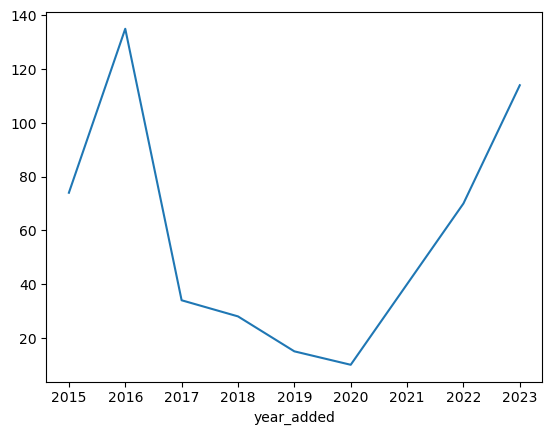

In [27]:
df['year_added'] = df['added_at'].str[:4] # Creating a year_added column.
songs_per_years = df['year_added'].value_counts().sort_index()
songs_per_years.plot()

### What era of rock music is most represented?
Perhaps unsuprisingly given my age (30 at time of writing), the 2010s were the most popular decade when looking at the number of songs added to the playlist by decade released.

<Axes: xlabel='release_date_decade'>

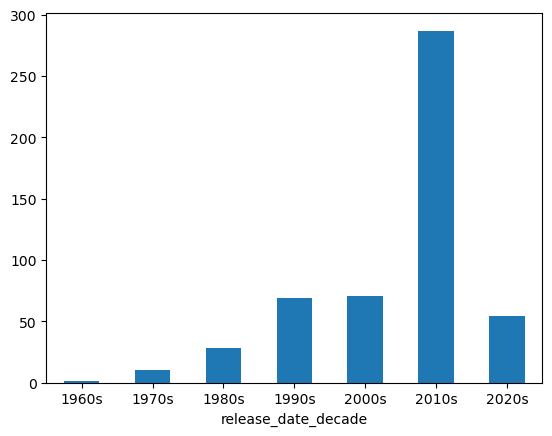

In [28]:
df['release_date_decade'] = df['release_date'].str[:3] + "0s"
rock_era_song_count = df['release_date_decade'].value_counts().sort_index()
rock_era_song_count.plot(kind="bar", rot=0)

### Looking at each era individually, which artist had the most songs featured in my playlist?

In [29]:
era_artists = df.groupby(['release_date_decade', 'artist_name']).size().reset_index(name='song_count')
max_count_id = era_artists.groupby('release_date_decade')['song_count'].idxmax()
top_artists_per_era = era_artists.loc[max_count_id]
top_artists_per_era

,release_date_decade,artist_name,song_count
0,1960s,The Beatles,1
3,1970s,David Bowie,2
15,1980s,Descendents,5
44,1990s,Nirvana,10
87,2000s,NOFX,8
283,2010s,Violent Soho,8
294,2020s,Amyl and The Sniffers,6


## Conclusion

Some interesting insights came out of this analysis, my favourites of which include:

- The longest song on my playlist is over 13 minutes long and the shortest is just over a minute long.

- The 2010s are my favourite era of rock music, going off of the number of songs from each decade of rock music.

- I added the most songs to the playlist in 2016 but since 2020 I've been adding more and more songs every year. 

Thanks for reading!

You can find this Jupyter Notebook in this [Github repo](https://github.com/ben-n93/spotify_rock_playlist_analysis).